## Final Project Submission

Please fill out:
* Student name: Jason Lombino
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:

In [1]:
import sqlite3
import pandas as pd
import gzip as gz
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)

if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
        zipfile.ZipFile.extractall(my_zip,path='zippedData/')

im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)

In [3]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype(int)
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)

In [4]:
def get_season(month):
    if month in ['Dec','Jan','Feb']:
        return 'Winter'
    elif month in ['Mar','Apr','May']:
        return 'Spring'
    elif month in ['Jun','Jul','Aug']:
        return 'Summer'
    else:
        return 'Autumn'


In [5]:
tn_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn = tn_movie_budgets[tn_cols]
tn = tn[tn['year'].astype(int) >= 2000]
tn['roi_%_domestic'] = 100*(tn['clean_domestic'] - tn['clean_budget']) / tn['clean_budget']
tn['roi_%_worldwide'] = 100*(tn['clean_worldwide'] - tn['clean_budget']) / tn['clean_budget']
tn['clean_profit'] = tn['clean_worldwide'] - tn['clean_budget']
tn['season'] = tn['month'].apply(get_season)

In [6]:
im_db_basics.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_cols = ['title','genres','runtime_minutes']
im_db_filtered = im_db_basics[im_db_cols]
combined_financial = im_db_filtered.merge(tn,on = 'title',how = 'inner')
combined_financial = combined_financial.drop_duplicates(subset = 'title', keep='first')


In [7]:
genre_set = set()
genre_df = combined_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
genre_set = sorted(list(genre_set))

In [8]:
genre_financials = pd.DataFrame()
for genre in genre_set:
    genre_specific_df = combined_financial[combined_financial['genres'].str.contains(genre) == True]
    #print(genre,len(genre_specific_df))
    genre_financials = pd.concat([genre_financials,genre_specific_df['roi_%_worldwide']],axis=1)
genre_financials.columns = genre_set

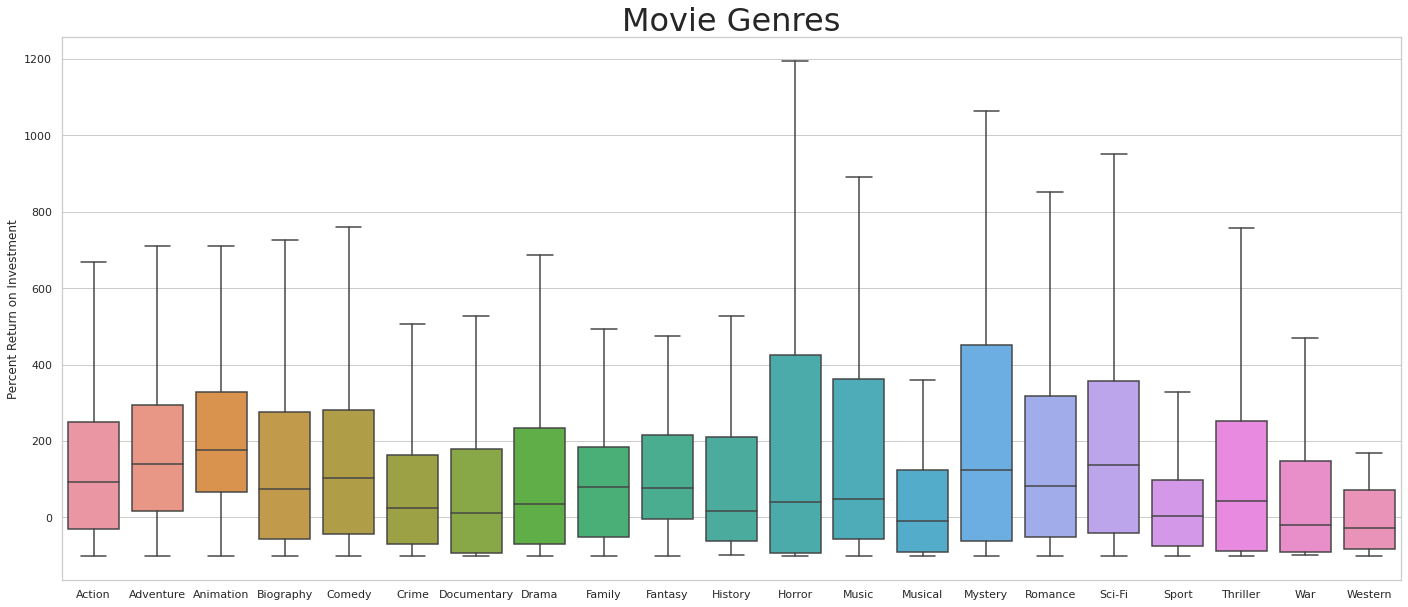

In [9]:

sns.set(rc={'figure.figsize':(24,10)})
sns.set_theme(style='whitegrid');
genre_plot_1 = sns.boxplot(data = genre_financials,showfliers = False)
genre_plot_1.set_ylabel('Percent Return on Investment');
genre_plot_1.set_title('Movie Genres',fontsize=32);

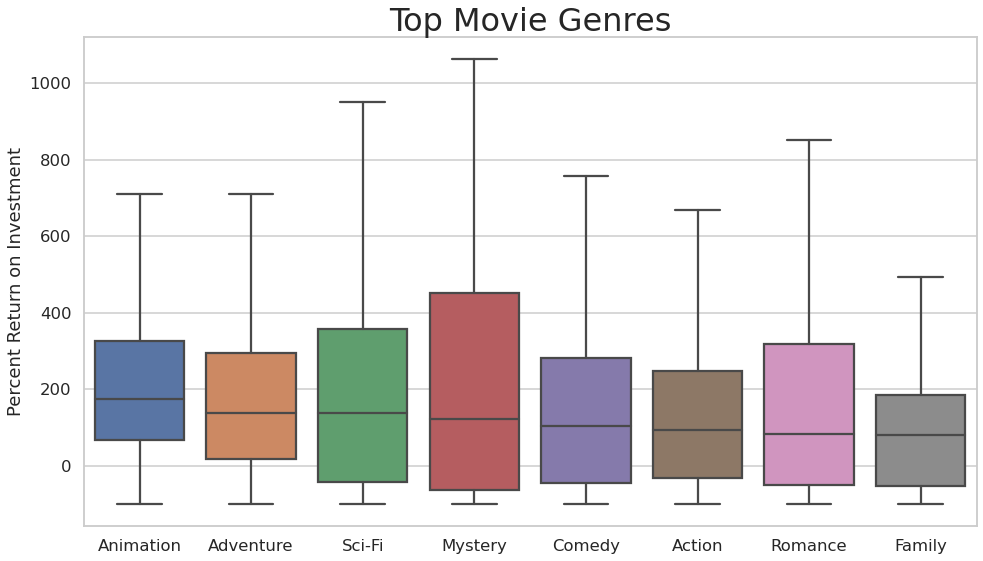

In [12]:
top_genre_financials = genre_financials[genre_financials.median().sort_values(ascending=False).index[:8]]
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style='whitegrid',context='talk');
genre_plot_2 = sns.boxplot(data = top_genre_financials,showfliers = False)
genre_plot_2.set_ylabel('Percent Return on Investment');
genre_plot_2.set_title('Top Movie Genres',fontsize=32);